# Advanced Numerical Analysis

## Exercise 52 - Heat flow through a thin strip

*Heat flow through a thin strip may be modeled by the heat equation* $u_t = c u_{xx}$ *on* $[0, T] \times [-L, L]$ *with initial conditions* $u(0, x) = u_0(x)$ *for* $x \in [-L, L]$ *and spatial boundary conditions* $u(t, x) = 0$ *for* $|x| = L.$ *For the numerical examples, let* $c = 1, L = \pi,$ *and* $T = 10.$

$\textrm{(i)} \quad$ *Write a program for finding* $u$ *given* $u_0,$ *using the method of lines with constant step size* $h$ *in time and finite differences for the spatial discretization, with constant mesh size* $\frac{L}{N}.$ *Allow solving the resulting ODE with any of the three half-step methods. In the implicit case (Crank–Nicholson method), use a sparse representation of the linear system.*

The function `solve_heat` defined below solves the heat equation

$$\begin{cases}
u_t = c u_{xx} \quad \textrm{on} \ (T_1, T_2) \times (L_1, L_2) \\
u(T_1,x) = u_0(x) \quad \forall x \in [L_1, L_2] \\
u(t,L_1) = a(t),\ u(t,L_2) = b(t) \quad \forall t \in [T_1, T_2]
\end{cases}$$

on a discretized rectangle with the following parameters:

`c` : float\
coefficient $c$ of heat equation $u_t = c u_{xx}$

`u0` : function handle\
function in variable $x$ of initial condition $u(T_1, x) = u_0(x)$

`a` : function handle\
function in variable $t$ of boundary condition $u(t, L_1) = a(t)$

`b` : function handle\
function in variable $t$ of boundary condition $u(t, L_2) = b(t)$

`t` : array\
discretized time interval $[T_1 = t_1,\, t_2,\, \dots,\, t_{M-1},\, t_M = T_2]$ of size $1 \times M$

`x` : array\
discretized space interval $[L_1 = x_1,\, x_2,\, \dots,\, x_{N-1},\, x_N = L_2]$ of size $1 \times N$

`method` : {1, 2, 3}, default 1\
first, second or third half step method to be used for solving the ODE

`tolerance` : float > 0, default $10^{-8}$\
tolerance for stopping the solver in the third half-step method

`max_iterations` : integer > 0, default 1000\
maximum number of iterations for solving the implicit equation in the third half-step method

In [89]:
function u = solve_heat(c, u0, a, b, t, x, method = 1, tolerance = 1e-8, max_iterations = 1000)
    
    M = length(t);
    N = length(x);
    u = zeros(N, M);
    
    # add initial and boundary values to solution array
    initial_values = u0(x);
    boundary_values_a = a(t);
    boundary_values_b = b(t);
    u(:, 1) = initial_values;
    u(1, :) = boundary_values_a;
    u(end, :) = boundary_values_b;
    
    # step sizes for time and space directions
    h = t(2:end) - t(1:end-1);
    k = x(2:end) - x(1:end-1);
    
    # construction of sparse system matrix
    F = spdiags(-(k(1:end-1) + k(2:end))', 0, N-2, N-2); # diagonal
    F = spdiags(k(3:end)', -1, F); # subdiagonal
    F = spdiags(k(1:end-2)', 1, F); # superdiagonal
    
    # function of ODE
    function U_prime = f(y, U)
        U_prime = F * U;
        U_prime(1) += a(y) / k(1) / k(2);
        U_prime(end) += b(y) / k(end)^2;
        U_prime *= c;
    endfunction
    
    if method == 1 # first half-step method: modified Euler method
        for i = 1 : M-1
            step = u(2:end-1,i) + h(i)/2 * f(t(i), u(2:end-1,i));
            u(2:end-1,i+1) = u(2:end-1,i) + h(i) * f(t(i) + h(i)/2, step);
        endfor
        return
        
    elseif method == 2 # second half-step method: method of Heun
        for i = 1 : M-1
            step = u(2:end-1,i) + h(i) * f(t(i), u(2:end-1,i));
            u(2:end-1,i+1) = u(2:end-1,i) + h(i)/2 * (f(t(i), u(2:end-1,i)) + f(t(i+1), step));
        endfor
        return
        
    elseif method == 3 # third half-step method: implicit midpoint rule
        for i = 1 : M-1
            # find root of function
            function z = fcn(y)
                z = f(t(i) + h(i)/2, u(2:end-1,i) + h(i)/2 * y) - y;
            endfunction
            
            options.TolX = tolerance;
            options.MaxIter = max_iterations;
            root = fsolve(@fcn, u(2:end-1,i), options);
            
            u(2:end-1,i+1) = u(2:end-1,i) + h(i) * root;
        endfor
        return
        
    else
        error("Not a valid method. Choose 1, 2 or 3 for a half-step method.")
    endif
        
endfunction

In [121]:
L = pi;
T = 10;
c = 1;

N = 10;
M = N;
t = linspace(0, T, M);
x = linspace(-L, L, 2*N+1);

a = @(t) zeros(size(t));
b = a;
u0 = @(x) sin(x) + sin(9*x);

approx = solve_heat(c, u0, a, b, t, x, 1);

u = @(t, x) sin(x) .* exp(-t) + sin(9*x) .* exp(-81*t);
[tt, xx] = meshgrid(t, x);
exact = u(tt, xx);

max_error = max(max(abs(exact - approx)))

max_error = 1.2028


In [123]:
approx

approx =

 Columns 1 through 8:

        0        0        0        0        0        0        0        0
  -0.6180  -0.4734  -0.3874  -0.3348  -0.3012  -0.2784  -0.2619  -0.2490
  -0.0000  -0.2356  -0.3610  -0.4242  -0.4526  -0.4615  -0.4596  -0.4519
  -1.6180  -1.2394  -1.0144  -0.8766  -0.7885  -0.7288  -0.6856  -0.6519
  -0.0000  -0.3812  -0.5840  -0.6864  -0.7323  -0.7467  -0.7437  -0.7312
  -2.0000  -1.5320  -1.2538  -1.0835  -0.9746  -0.9008  -0.8474  -0.8058
   0.0000  -0.3812  -0.5840  -0.6864  -0.7323  -0.7467  -0.7437  -0.7312
  -1.6180  -1.2394  -1.0144  -0.8766  -0.7885  -0.7288  -0.6856  -0.6519
   0.0000  -0.2356  -0.3610  -0.4242  -0.4526  -0.4615  -0.4596  -0.4519
  -0.6180  -0.4734  -0.3874  -0.3348  -0.3012  -0.2784  -0.2619  -0.2490
        0        0        0        0        0  -0.0000  -0.0000  -0.0001
   0.6180   0.4734   0.3874   0.3348   0.3012   0.2783   0.2617   0.2487
  -0.0000   0.2356   0.3610   0.4242   0.4525   0.4612   0.4590   0.4508
   1.6180   1.2394

In [111]:
exact

exact =

 Columns 1 through 8:

  -0.0000  -0.0000  -0.0000  -0.0000  -0.0000  -0.0000  -0.0000  -0.0000
  -0.6180  -0.1017  -0.0335  -0.0110  -0.0036  -0.0012  -0.0004  -0.0001
  -0.0000  -0.1935  -0.0637  -0.0210  -0.0069  -0.0023  -0.0007  -0.0002
  -1.6180  -0.2663  -0.0877  -0.0289  -0.0095  -0.0031  -0.0010  -0.0003
  -0.0000  -0.3131  -0.1031  -0.0339  -0.0112  -0.0037  -0.0012  -0.0004
  -2.0000  -0.3292  -0.1084  -0.0357  -0.0117  -0.0039  -0.0013  -0.0004
   0.0000  -0.3131  -0.1031  -0.0339  -0.0112  -0.0037  -0.0012  -0.0004
  -1.6180  -0.2663  -0.0877  -0.0289  -0.0095  -0.0031  -0.0010  -0.0003
   0.0000  -0.1935  -0.0637  -0.0210  -0.0069  -0.0023  -0.0007  -0.0002
  -0.6180  -0.1017  -0.0335  -0.0110  -0.0036  -0.0012  -0.0004  -0.0001
        0        0        0        0        0        0        0        0
   0.6180   0.1017   0.0335   0.0110   0.0036   0.0012   0.0004   0.0001
  -0.0000   0.1935   0.0637   0.0210   0.0069   0.0023   0.0007   0.0002
   1.6180   0.2663 

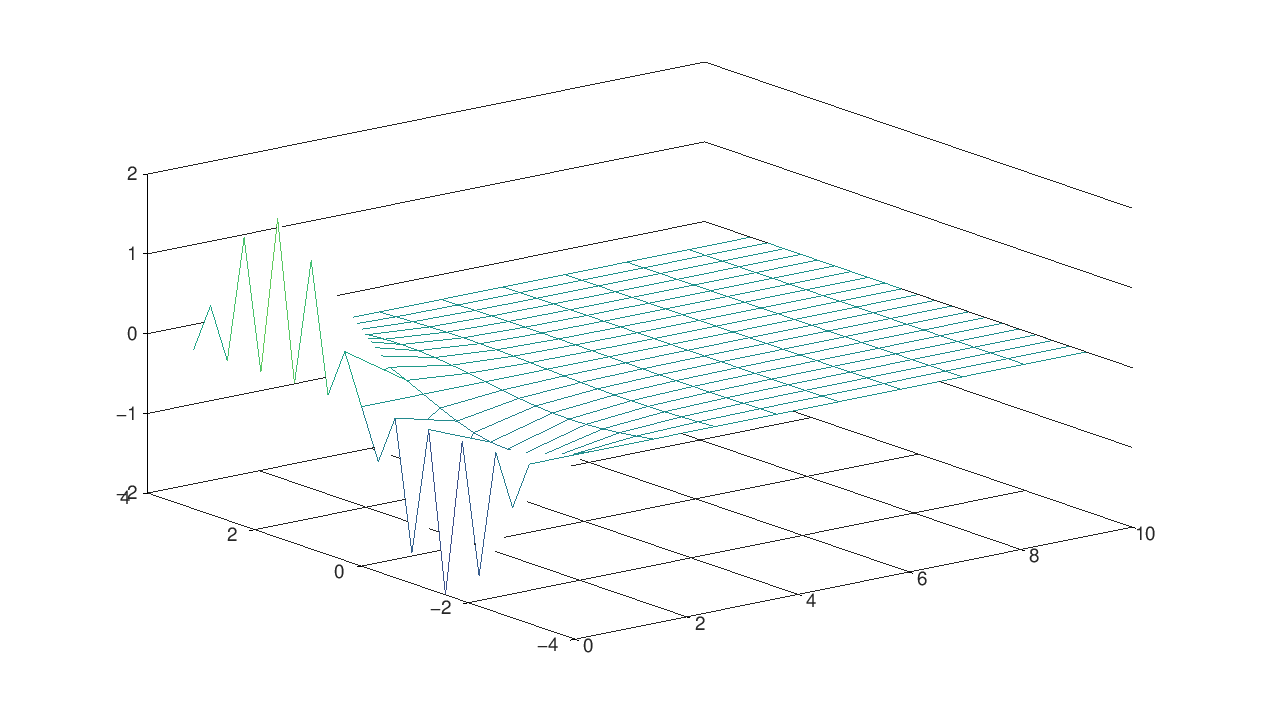

In [116]:
%plot -s 1280,720

mesh(t, x, exact)

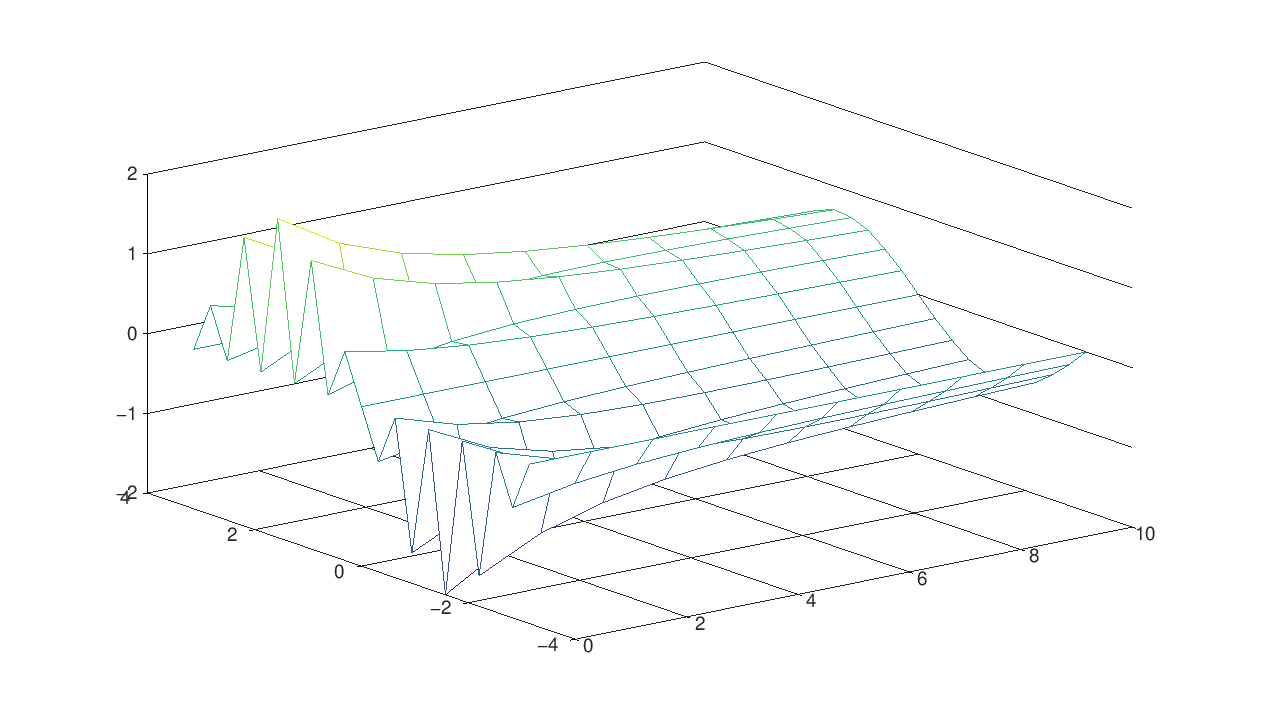

In [122]:
mesh(t, x, approx)

$$ $$
$\textrm{(ii)} \quad$ *Show that* $u(t, x) = \sin(x) e^{-t} + \sin(9x) e^{-81t}$ *solves the heat equation for the initial conditions* $u_0(x) = \sin(x) + \sin(9x).$


$$ $$
$\textrm{(iii)} \quad$ *For each pair* $(N,$ `method`$)\, \in \{ 10, 100, 1000 \} \times \{ 1, 2, 3 \},$ *find the largest time step* $h = 2−k$ *for which the error of the solution in the maximum norm is less than 1.2 times the error of the step size* $h = 2−k−1.$ *Interpret the findings.*

$$ $$
$\textrm{(iv)} \quad$ *For the step sizes found in* $\textrm{(iii)},$ *solve the problem for* $u_0(x) = x - \pi \, \textrm{sign}(x).$


$$ $$
$\textrm{(v)} \quad$ *Describe the effect of time on the solutions of* $\textrm{(iii)}$ *and* $\textrm{(iv)}.$